# Исследование тарифных планов сотовой связи

**Описание тарифных планов оператора сотовой связи**

*Тариф «Смарт»*
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

*Примечание:*

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Обзор данных

In [1]:
import pandas as pd  #импорт библиотеки pandas
import matplotlib.pyplot as plt #импорт библиотеки matplotlib
from scipy import stats as st #импорт функции stats из библиотеки scipy
import numpy as np #импорт библиотеки numpy
from functools import reduce #импорт функции reduce из библиотеки functools

In [2]:
users = pd.read_csv('users.csv')  #чтение файла `users.csv` и сохранение в переменной `users`

In [3]:
users.head() # просмотр первых 5 строк таблицы `users`

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info() #получение общей информации о таблице `users`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице 8 столбцов. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `user_id` — уникальный идентификатор пользователя;
* `first_name` — имя пользователя;
* `last_name` — фамилия пользователя;
* `age` — возраст пользователя (годы);
* `reg_date` — дата подключения тарифа (день, месяц, год);
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* `city` — город проживания пользователя;
* `tarif` — название тарифного плана.

Названия столбцов корректные в соответствие с хорошим стилем, исправление названий не требуется.

Количество значений отличается только в столбце `churn_date`. Значит, в нём есть пропущенные значения. Однако в документации указно, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Необходимо учесть это при предобработке данных.

In [5]:
tarif = pd.read_csv('tariffs.csv')  #чтение файла tariffs.csv и сохранение в переменной `tarif`

In [6]:
tarif # просмотр таблицы `tarif`

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
tarif.info() #получение общей информации о таблице `tarif`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице 8 столбцов. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `tariff_name` — название тарифа;
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях;
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату;
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату;
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета;
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

Названия столбцов корректные в соответствие с хорошим стилем, исправление названий не требуется. Однако, и в таблице `users.csv`, и в таблице `tariffs.csv` есть столбец с одинаковым наполнением, но разными названиями: название тарифного плана. В `users.csv` это столбец с названием `tarif`, а в `tariffs.csv` - `tariff_name`. Следует привести их к одинаковому названию для дальнейшего удобства работы с таблицами.

Количество значений в столбцах не отличается. Значит, пропущенных значений нет.

In [8]:
calls = pd.read_csv('calls.csv')  #чтение файла calls.csv и сохранение в переменной `calls`

In [9]:
calls.head() # просмотр первых 5 строк таблицы `calls`

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
calls.info() #получение общей информации о таблице `calls`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице 4 столбца. Типы данных в столбцах: object, int64 и float64.

Согласно документации к данным:
* `id` — уникальный номер звонка;
* `call_date` — дата звонка;
* `duration` — длительность звонка в минутах;
* `user_id` — идентификатор пользователя, сделавшего звонок.

Названия столбцов корректные в соответствие с хорошим стилем, исправление названий не требуется.

Количество значений в столбцах не отличается. Значит, пропущенных значений нет.

In [11]:
message = pd.read_csv('messages.csv')  #чтение файла messages.csv и сохранение в переменной `message`

In [12]:
message.head() # просмотр первых 5 строк таблицы `message`

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
message.info() #получение общей информации о таблице `message`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице 3 столбца. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `id` — уникальный номер сообщения;
* `message_date` — дата сообщения;
* `user_id` — идентификатор пользователя, отправившего сообщение.

Названия столбцов корректные в соответствие с хорошим стилем, исправление названий не требуется.

Количество значений в столбцах не отличается. Значит, пропущенных значений нет.

In [14]:
internet = pd.read_csv('internet.csv')  #чтение файла internet.csv и сохранение в переменной `internet`

In [15]:
internet.head() # просмотр первых 5 строк таблицы `internet`

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [16]:
internet.info() #получение общей информации о таблице `internet`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице 5 столбцов. Типы данных в столбцах: object, int64 и float64.

Согласно документации к данным столбцов должно быть 4:
* `id` — уникальный номер сессии;
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах);
* `session_date` — дата интернет-сессии;
* `user_id` — идентификатор пользователя.

Столбец `Unnamed: 0` в документации не упоминается, судя по его значениям он дублирует номера индексов строк, необходимо удалить его на этапе предобработки данных.

Названия остальных столбцов корректные в соответствие с хорошим стилем, исправление названий не требуется.

Количество значений в столбцах не отличается. Значит, пропущенных значений нет.

### Выводы

В каждой строке таблицы `users` - данные о пользователях компании «Мегалайн» на тарифных плана: «Смарт» и «Ультра». Часть колонок рассказывает о самих пользователях: имя, фамилия, возраст, город. Другая часть - о тарифе пользователя: название, дата подключения, дата отключения.

В каждой строке таблицы `tarif` - данные о параметрах тарифных планов «Смарт» и «Ультра»: название, размер абон.платы, размеры пакетов минут, сообщений и интернета, стоимость трафика сверх пакета.

В каждой строке таблицы `calls` - данные о звонках пользователей компании «Мегалайн»: дата звонка, длительность и уникальный номер звонка.

В каждой строке таблицы `message` - данные о сообщениях пользователей компании «Мегалайн»: дата сообщения и уникальный номер сообщения.

В каждой строке таблицы `internet` - данные об интернет-сессиях пользователей компании «Мегалайн»: дата интернет-сессии, объём потраченного интернет-трафика  и уникальный номер сессии.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Пропуски в данных присутствуют только в одном столбце - `churn_date`, и при этом в документации есть пояснение их значения. Названии колонок записаны в соответствие с хорошим стилем, однако требуется переименовать название столбца с названием тарифного плана в таблице `tarif` для удобства работы с данными. В таблице `internet` присутствует столбец, который не описан в документации, необходимо обработать его на следующем этапе.

Также в документации указно, что в столбце `duration` таблицы `calls` могут встречаться нулевые значения и это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Чтобы двигаться дальше, нужно устранить проблемы в данных и объединить таблицы в общий датасет для удобства дальнешей работы.

## Предобработка данных

### Заполнение пропусков

Пропущенные значения присутствуют в столбце `churn_date` таблицы `users`. Однако из документации нам известно, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. В таком случае предлагается заполить данные пропуски служебным значением -1.

In [17]:
users.isna().mean() #информация о доле пропущенных значений в каждом из столбцов таблицы

user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

In [18]:
#заполняем пропущенные значения в столбце `churn_date` -1
users['churn_date'] = users['churn_date'].fillna(-1)
len(users[users['churn_date'].isna()]) #проверяем, что в датафрейме нет пропусков в столбце `churn_date`

0

**Выводы**

На данном этапе мы обработали пропущенные значения, которые были обнаружены в столбце `churn_date`. Так как причина пропущенных значений была описана в документаци, пропуски мы заменили на служебное значение -1.

### Названия столбцов

На этапе обзора данных мы обнаружили, что и в таблице `users`, и в таблице `tarif` есть столбец с одинаковым наполнением, но разными названиями: название тарифного плана. В `users` это столбец с названием `tariff`, а в `tarif` - `tariff_name`. Следует привести их к одинаковому названию для дальнейшего удобства работы с таблицами.

In [19]:
# Переименуем столбец `tariff_name` в таблице `tarif` и назовём его также, как в таблице `users`
tarif = tarif.rename(columns={'tariff_name': 'tariff'})
tarif.columns #проверим успешность переименования

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

**Выводы**

На данном этапе мы привели в соответствие название столбцов `tarif` в таблице `users` и `tariff_name` в таблице `tarif`, так как их наполнение и логический смысл одинаковые. Столбец `tariff_name` был переименован в `tariff`.

### Удаление несущественных столбцов

На этапе обзора данных мы обнаружили, что и в таблице `internet` имеется столбец `Unnamed: 0`, который не упоминается в документации, и, судя по его значениям, он дублирует номера индексов строк. Предлагается удалить данный столбец.

In [20]:
internet = internet.drop(['Unnamed: 0'], axis=1)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Выводы**

На данном этапе мы удалили столбец `Unnamed: 0` из таблицы `internet`, так как в документации он не упоминается и, судя по его значениям, он дублирует номера индексов строк.

### Подготовка данных в таблице `calls` для проверки гипотез

Для проверки гипотез нам необходимо рассчитать количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.

In [21]:
calls.sample(5) # просмотр 5 случайных строк таблицы `calls`

,id,call_date,duration,user_id
11148,1029_37,2018-12-01,5.90,1029
122760,1317_269,2018-11-01,1.35,1317
181783,1453_975,2018-05-22,17.93,1453
40591,1100_114,2018-09-21,5.53,1100
73111,1184_85,2018-09-13,9.61,1184


In [22]:
calls.info() #получение общей информации о таблице `calls`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Можно заметить, что столбцы `id` и `call_date` находятся в формате `object`, хотя данные в столбце `id` должны быть, также как и в столбце `user_id` в формате `int64`, а в столбце `call_date` - в формате `datetime`.

In [23]:
# Преобразуем формат данных в столбце `call_date` в формат `datetime`
calls['call_date'] = pd.to_datetime(calls.call_date)

In [24]:
# Преобразуем формат данных в столбце `id` в формат `int64`
calls['id'] = calls['id'].astype('int')

In [25]:
calls.info() #проверим, что формат данных изменён

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.2 MB


Также мы видим, что данные в столбце `duration` не округленные, хотя по условиях тарифных планов «Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Необходимо округлить данные в столбце `duration` в большую сторону.

In [26]:
#округляем длительность звонков в большую сторону и записываем в отдельный столбец `duration_round`
calls['duration_round'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id,duration_round
0,10000,2018-07-25,0.00,1000,0.0
1,10001,2018-08-17,0.00,1000,0.0
2,10002,2018-06-11,2.85,1000,3.0
3,10003,2018-09-21,13.80,1000,14.0
4,10004,2018-12-15,5.18,1000,6.0


In [27]:
# Преобразуем формат данных в столбце `duration_round` в формат `int64`
calls['duration_round'] = calls['duration_round'].astype('int')
calls.head(3)

,id,call_date,duration,user_id,duration_round
0,10000,2018-07-25,0.00,1000,0
1,10001,2018-08-17,0.00,1000,0
2,10002,2018-06-11,2.85,1000,3


In [28]:
# теперь посмотрим общую информацию о данных по столбцам
calls.describe()

,id,duration,user_id,duration_round
count,2.026070e+05,202607.000000,202607.000000,202607.000000
mean,1.212254e+06,6.755887,1253.940619,7.158198
std,1.725756e+06,5.843365,144.722751,5.959173
min,1.000000e+04,0.000000,1000.000000,0.000000
25%,1.012286e+06,1.300000,1126.000000,2.000000
50%,1.179376e+06,6.000000,1260.000000,6.000000
75%,1.358126e+06,10.700000,1379.000000,11.000000
max,1.458115e+07,38.000000,1499.000000,38.000000


По данной таблице видим, что средння продолжительность округлённого звонка (7,16) не очень сильно отличается от медианы (6).

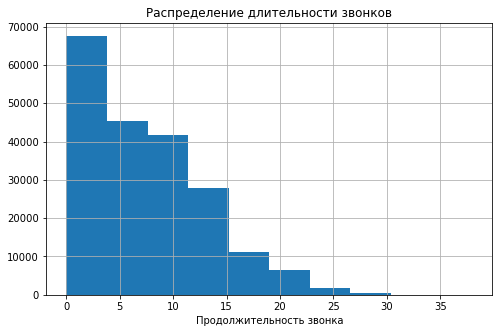

In [29]:
#построим гистограмму для параметра длительность звонка
plt.figure(figsize=(8,5))
calls['duration_round'].hist()
plt.xlabel('Продолжительность звонка')
plt.title('Распределение длительности звонков')
plt.show()

На графике видим, что в большинство звонков длительностью 0-4 минуты. Распределение частот продолжительности звонков является Пуассоновским, что логично для длительности звонков.

In [30]:
# Обернём график в функцию для дальнейшего использования
def buildHist(data, xname, title):
    plt.figure(figsize=(8,5))
    data.hist()
    plt.xlabel(xname)
    plt.title(title)
    plt.ticklabel_format(style='plain') # убираем scientific notation
    plt.show()

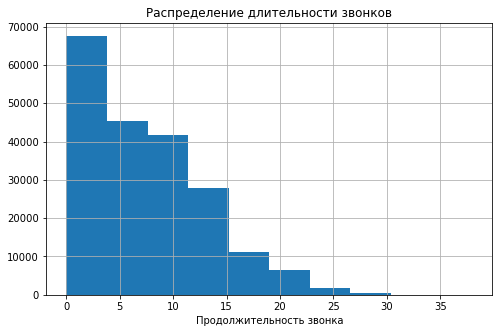

In [31]:
# проверяем работу функции
buildHist(calls['duration_round'], 'Продолжительность звонка', 'Распределение длительности звонков')

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам. Для этого в таблицу `calls` добавим столбец с месяцем звонка.

In [32]:
calls['call_month'] = calls['call_date'].astype('datetime64[M]')
calls.head()

,id,call_date,duration,user_id,duration_round,call_month
0,10000,2018-07-25,0.00,1000,0,2018-07-01
1,10001,2018-08-17,0.00,1000,0,2018-08-01
2,10002,2018-06-11,2.85,1000,3,2018-06-01
3,10003,2018-09-21,13.80,1000,14,2018-09-01
4,10004,2018-12-15,5.18,1000,6,2018-12-01


In [33]:
# сгруппируем таблицу по пользователям и месяцам посмотрим сумму минут в месяц
calls_pivot = (
    calls.pivot_table(index=['user_id','call_month'], values='duration_round', aggfunc=['count', 'sum'])
    .reset_index()
)
calls_pivot.head()

,user_id,call_month,count,sum
,,,duration_round,duration_round
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


In [34]:
calls_pivot.columns = ['user_id', 'month', 'call_count', 'call_vol']
calls_pivot.head(5)

,user_id,month,call_count,call_vol
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


**Выводы**

На данном этапе мы преобразовали типы данных в столбцах `id` и `call_date` и изменили их на `int64` и `datetime` соответственно для удобства дальнейшей работы. Посмотрели общую информацию о продолжительности звонков пользователей тарифов. Сгруппировали данные по пользователям и месяцам и рассчитали количество израсходованных минут разговора в месяц на каждого пользователя.

### Подготовка данных в таблице `message` для проверки гипотез

Для проверки гипотез нам необходимо рассчитать количество отправленных сообщений по месяцам для каждого пользователя.

In [35]:
message.sample(5) # просмотр 5 случайных строк таблицы `message`

,id,message_date,user_id
106723,1431_465,2018-04-17,1431
81766,1343_8,2018-10-17,1343
32077,1144_216,2018-09-11,1144
84830,1354_282,2018-12-04,1354
37761,1165_115,2018-11-25,1165


In [36]:
message.info() #получение общей информации о таблице `message`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Можно заметить, что столбцы `id` и `message_date` находятся в формате `object`, хотя данные в столбце `id` должны быть, также как и в столбце `user_id` в формате `int64`, а в столбце `message_date` - в формате `datetime`.

In [37]:
# Преобразуем формат данных в столбце `message_date` в формат `datetime`
message['message_date'] = pd.to_datetime(message.message_date)

In [38]:
# Преобразуем формат данных в столбце `id` в формат `int64`
message['id'] = message['id'].astype('int')

In [39]:
message.info() #проверим, что формат данных изменён

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам. Для этого в таблицу `message` добавим столбец с месяцем звонка.

In [40]:
message['mes_month'] = message['message_date'].astype('datetime64[M]')
message.head()

,id,message_date,user_id,mes_month
0,10000,2018-06-27,1000,2018-06-01
1,10001,2018-10-08,1000,2018-10-01
2,10002,2018-08-04,1000,2018-08-01
3,10003,2018-06-16,1000,2018-06-01
4,10004,2018-12-05,1000,2018-12-01


In [41]:
# сгруппируем таблицу по пользователям и месяцам посмотрим количество отправленных сообщений
message_pivot = (
    message.pivot_table(index=['user_id', 'mes_month'], values='id', aggfunc='count').reset_index()
)
message_pivot.head()

,user_id,mes_month,id
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


In [42]:
message_pivot.columns = ['user_id', 'month', 'mes_count']
message_pivot.head()

,user_id,month,mes_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


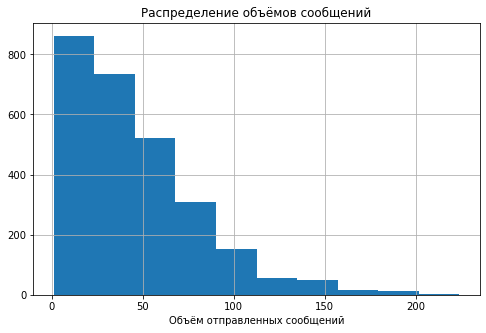

In [43]:
# посмотрим распределение частот объёмов отправленных сообщений в месяц
buildHist(message_pivot['mes_count'], 'Объём отправленных сообщений', 'Распределение объёмов сообщений')

На графике видим, что большинство объёмов отправленных сообщений находится в интервале 1-20 сообщений в месяц. Распределение частот объёмов отправленных сообщений является Пуассоновским.

**Выводы**

На данном этапе мы преобразовали типы данных в столбцах `id` и `message_date` и изменили их на `int64` и `datetime` соответственно для удобства дальнейшей работы. Сгруппировали данные по пользователям и месяцам и рассчитали среднее количество отправленных сообщений в месяц на каждого пользователя. Посмотрели общую информацию об объёмах отправленных сообщений пользователей тарифов в месяц.

### Подготовка данных в таблице `internet` для проверки гипотез

Для проверки гипотез нам необходимо рассчитать объем израсходованного интернет-трафика по месяцам для каждого пользователя.

In [44]:
internet.sample(5) # просмотр 5 случайных строк таблицы `internet`

,id,mb_used,session_date,user_id
37003,1127_353,140.39,2018-11-23,1127
99460,1332_434,586.60,2018-08-25,1332
98050,1330_258,564.89,2018-11-14,1330
142603,1477_500,520.81,2018-08-17,1477
100467,1337_504,0.00,2018-07-15,1337


In [45]:
internet.info() #получение общей информации о таблице `internet`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Можно заметить, что столбцы `id` и `session_date` находятся в формате `object`, хотя данные в столбце `id` должны быть, также как и в столбце `user_id` в формате `int64`, а в столбце `session_date` - в формате `datetime`.

In [46]:
# Преобразуем формат данных в столбце `session_date` в формат `datetime`
internet['session_date'] = pd.to_datetime(internet.session_date)

In [47]:
# Преобразуем формат данных в столбце `id` в формат `int64`
internet['id'] = internet['id'].astype('int')

In [48]:
internet.info() #проверим, что формат данных изменён

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int64         
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.6 MB


Также мы видим, что данные в столбце `mb_used` в мегабайтах и не округленные, хотя по условиях тарифных планов «Мегалайн» всегда округляет мегабайты до гигабайт. Отдельные сессии не считаются, вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Необходимо округлить посчитать сумму мегабайт для каждого пользователя по месяцам, далее перевести мегабайты в гигабайты и округлить их в большую сторону.

In [49]:
#добавим в таблицу `internet` столбец с месяцем интернет-сессии
internet['ses_month'] = internet['session_date'].astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,ses_month
0,10000,112.95,2018-11-25,1000,2018-11-01
1,10001,1052.81,2018-09-07,1000,2018-09-01
2,10002,1197.26,2018-06-25,1000,2018-06-01
3,10003,550.27,2018-08-22,1000,2018-08-01
4,10004,302.56,2018-09-24,1000,2018-09-01


In [50]:
# сгруппируем таблицу по пользователям и посмотрим объем израсходованного интернет-трафика по месяцам
int_pivot = (
    internet.pivot_table(index=['user_id', 'ses_month'], values='mb_used', aggfunc='sum')
    .reset_index()
)
int_pivot.tail()

,user_id,ses_month,mb_used
3198,1498,2018-10-01,20579.36
3199,1499,2018-09-01,1845.75
3200,1499,2018-10-01,17788.51
3201,1499,2018-11-01,17963.31
3202,1499,2018-12-01,13055.58


In [51]:
#переводим мегабайты в гигабайты, округляем в большую сторону
int_pivot['mb_used'] = int_pivot['mb_used'].apply(lambda x: np.ceil(x / 1024))
int_pivot.tail()

,user_id,ses_month,mb_used
3198,1498,2018-10-01,21.0
3199,1499,2018-09-01,2.0
3200,1499,2018-10-01,18.0
3201,1499,2018-11-01,18.0
3202,1499,2018-12-01,13.0


In [52]:
int_pivot.columns = ['user_id', 'month', 'gb_used']
int_pivot.tail()

,user_id,month,gb_used
3198,1498,2018-10-01,21.0
3199,1499,2018-09-01,2.0
3200,1499,2018-10-01,18.0
3201,1499,2018-11-01,18.0
3202,1499,2018-12-01,13.0


In [53]:
# теперь посмотрим общую информацию о данных по столбцам
int_pivot['gb_used'].describe()

count    3203.000000
mean       17.358414
std         7.343379
min         0.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        49.000000
Name: gb_used, dtype: float64

По данной таблице видим, что среднний объём интернет-трафика в месяц (17,36) не очень сильно отличается от медианы (17).

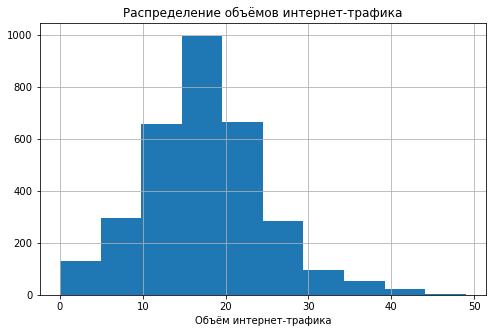

In [54]:
# посмотрим распределение частот объёмов интернет-трафика в месяц
buildHist(int_pivot['gb_used'], 'Объём интернет-трафика', 'Распределение объёмов интернет-трафика')

На графике видим, что большинство объёмов интернет-трафика находится в интервале 15-19 гигабайт в месяц. Распределение частот объёмов интернет-трафика является нормальным.

**Выводы**

На данном этапе мы преобразовали типы данных в столбцах `id` и `session_date` и изменили их на `int64` и `datetime` соответственно для удобства дальнейшей работы. Посмотрели общую информацию об объёмах израсходованного интернет-трафика  пользователей тарифов. Сгруппировали данные по пользователям и месяцам и рассчитали средний объём израсходованного интернет-трафика в месяц на каждого пользователя.

### Подготовка данных в таблице `tarif` для проверки гипотез

In [55]:
tarif

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице `tarif` объём интернет-трафика указан в мегабайтах, однако нам для проверки гипотез удобнее использовать объёмы в гигабайтах. Переведём значения столбца `mb_per_month_included` в нужные единицы и переименуем столбец.

In [56]:
# переводим мегабайты в гигабайты
tarif['mb_per_month_included'] = tarif['mb_per_month_included'] / 1024
tarif

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


In [57]:
# меняем формат данных в столбце `mb_per_month_included` на `int64`
tarif['mb_per_month_included'] = tarif['mb_per_month_included'].astype('int')
tarif

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [58]:
# переименуем столбец `mb_per_month_included` в `gb_per_month_included`
tarif = tarif.rename(columns={'mb_per_month_included': 'gb_per_month_included'})

In [59]:
# проверим изменения
tarif

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Расчёт помесячной выручки с каждого пользователя

Для того чтобы рассчитать помесячную выручку с каждого пользователя необходимо объединить данные из таблиц `users`, `tarif`, `calls_pivot`, `message_pivot` и `int_pivot`. Создадим таблицу `df`, в которую соберём все необходимы нам данные.

In [60]:
data_frames = [calls_pivot, message_pivot, int_pivot]
traffic = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_frames)
traffic.head()

,user_id,month,call_count,call_vol,mes_count,gb_used
0,1000,2018-05-01,22.0,159.0,22.0,3.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0


In [61]:
# заполним 0 значения трафика, которого у клиентов не было
traffic = traffic.fillna(0)
traffic.isna().mean()

user_id       0.0
month         0.0
call_count    0.0
call_vol      0.0
mes_count     0.0
gb_used       0.0
dtype: float64

In [62]:
# объединим нужные нам таблицы в одну общую `df` по `user_id`
data_frames = [users, traffic]
df = reduce(lambda left,right: pd.merge(left,right,on=['user_id'], how='outer'), data_frames)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0


В данном случае будем считать, что в случае проусков в столбцах с объёмами минут, сообщений и интернет-трафика данного трафика у пользователей не было, поэтому заменим пропуски на 0.

In [63]:
df.isna().mean()

user_id       0.000000
age           0.000000
churn_date    0.000000
city          0.000000
first_name    0.000000
last_name     0.000000
reg_date      0.000000
tariff        0.000000
month         0.000622
call_count    0.000622
call_vol      0.000622
mes_count     0.000622
gb_used       0.000622
dtype: float64

In [64]:
df = df.dropna()

In [65]:
# добавим в таблицу `df` параметры тарифов «Смарт» и «Ультра»
df = df.merge(tarif, on='tariff', how='left')
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1000,30,3000,1950,150,1,1
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1000,30,3000,1950,150,1,1
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1000,30,3000,1950,150,1,1
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1000,30,3000,1950,150,1,1
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1000,30,3000,1950,150,1,1


Вычислим выручку от тарифных планов по пользователям: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану. Сохраним рассчётное значение в столбце `tariff_revenue`.

In [66]:
df['rub_min_over'] = (
    np.where((df['call_vol'] - df['minutes_included']) <= 0, 0 ,
             (df['call_vol'] - df['minutes_included']) * df['rub_per_minute'])
)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,...,mes_count,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_min_over
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,...,22.0,3.0,1000,30,3000,1950,150,1,1,0.0
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,...,60.0,23.0,1000,30,3000,1950,150,1,1,0.0
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,...,75.0,14.0,1000,30,3000,1950,150,1,1,0.0
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,...,81.0,14.0,1000,30,3000,1950,150,1,1,0.0
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,...,57.0,15.0,1000,30,3000,1950,150,1,1,0.0


In [67]:
pd.set_option('display.max_columns', None)

In [68]:
df['rub_mes_over'] = (
    np.where((df['mes_count'] - df['messages_included']) <= 0, 0 ,
             (df['mes_count'] - df['messages_included']) * df['rub_per_message'])
)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_min_over,rub_mes_over
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1000,30,3000,1950,150,1,1,0.0,0.0
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1000,30,3000,1950,150,1,1,0.0,0.0
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1000,30,3000,1950,150,1,1,0.0,0.0


In [69]:
df['rub_gb_over'] = (
    np.where((df['gb_used'] - df['gb_per_month_included']) <= 0, 0 ,
             (df['gb_used'] - df['gb_per_month_included']) * df['rub_per_gb'])
)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_min_over,rub_mes_over,rub_gb_over
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0


In [70]:
df['revenue'] = df['rub_monthly_fee'] + df['rub_min_over'] + df['rub_mes_over'] + df['rub_gb_over']
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_min_over,rub_mes_over,rub_gb_over,revenue
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


Оставим в финальной таблице только те столбцы, которые нужны для последующего анализа и проверки гипотез.

In [71]:
df_final = df[['user_id', 'churn_date', 'city', 'reg_date', 'tariff', 'month', 'call_count', 'call_vol',
              'mes_count', 'gb_used', 'revenue']]
df_final.head(3)

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
0,1000,-1,Краснодар,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1950.0
1,1000,-1,Краснодар,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1950.0
2,1000,-1,Краснодар,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1950.0


**Выводы**

На данном этапе мы собрали все необходимые для анализа данные в общую таблицу `df_final`, заменили пропущенные значения, которые получились в результате объединения таблиц и рассчитали вуручку по месяцам от клиентов по тарифам.

### Выводы

На данном этапе мы подготовили данные для дальнейшего анализа и проверки гипотез:
* обработали пропуски в таблице `users` в соответствие с описанием в документации;
* привели в соотвествие название столбца  с тарифом в таблицах `users` и `tarif`;
* удалили несущественный столбец из таблицы `internet`;
* подготовили сводные таблицы с объёмами минут, сообщений и интернет-трафика в месяц по пользователям;
* подготовили таблицу `tarif` для дальнейшей работы;
* собрали все необходимые для рассчетов и анализа данные в таблицу `df_final` и рассчитали выручку в месяц по пользователям тарифов.

## Исследовательский анализ данных

Проанализируем основные метрики потребления трафика и выручки пользователей тарифных планов «Смарт» и «Ультра». Добавим в таблицу `df_final` столбцы со средним объёмом минут, сообщений, интернет-трафика и средней выручкой в месяц.

In [72]:
# сохраним в переменную `smart` все данные о пользователях на тарифе «Смарт»
smart = df_final.query('tariff == "smart"')
smart.head()

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
8,1001,-1,Москва,2018-11-01,smart,2018-11-01,59.0,430.0,0.0,18.0,1150.0
9,1001,-1,Москва,2018-11-01,smart,2018-12-01,63.0,414.0,0.0,14.0,550.0
10,1002,-1,Стерлитамак,2018-06-17,smart,2018-06-01,15.0,117.0,4.0,11.0,550.0
11,1002,-1,Стерлитамак,2018-06-17,smart,2018-07-01,26.0,214.0,11.0,18.0,1150.0
12,1002,-1,Стерлитамак,2018-06-17,smart,2018-08-01,42.0,289.0,13.0,20.0,1550.0


In [73]:
# сохраним в переменную `ultra` все данные о пользователях на тарифе «Ультра»
ultra = df_final.query('tariff == "ultra"')
ultra.head()

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
0,1000,-1,Краснодар,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1950.0
1,1000,-1,Краснодар,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1950.0
2,1000,-1,Краснодар,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1950.0
3,1000,-1,Краснодар,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1950.0
4,1000,-1,Краснодар,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1950.0


In [74]:
# посмотрим общую информацию о среднем трафике и выручке в месяц пользователей таблицы `smart`
smart[['call_count', 'call_vol', 'mes_count', 'gb_used', 'revenue']].describe()

,call_count,call_vol,mes_count,gb_used,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,58.463437,417.934948,33.384029,16.328847,1289.973531
std,25.939858,190.313730,28.227876,5.747061,818.404367
min,0.000000,0.000000,0.000000,0.000000,550.000000
25%,40.000000,282.000000,10.000000,13.000000,550.000000
50%,60.000000,422.000000,28.000000,17.000000,1023.000000
75%,76.000000,545.000000,51.000000,20.000000,1750.000000
max,198.000000,1435.000000,143.000000,38.000000,6770.000000


Из таблицы видно, что в среднем пользователи тарифа «Смарт» не расходуют полностью пакеты минут и сообщений, включенных в тариф: 418 минут из 500 доступных и 33 сообщения из 50 доступных, при этом пакет интернета в среднем перерасходуется на 1,3 гигабайта. Также стоит отметить, что стандартное отклонение метрик достаточно велико.

In [75]:
# посмотрим общую информацию о среднем трафике и выручке в месяц пользователей таблицы `ultra`
ultra[['call_count', 'call_vol', 'mes_count', 'gb_used', 'revenue']].describe()

,call_count,call_vol,mes_count,gb_used,revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,73.392893,526.623350,49.363452,19.494416,2070.152284
std,43.916853,317.606098,47.804457,9.853511,376.187114
min,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,41.000000,284.000000,6.000000,12.000000,1950.000000
50%,74.000000,518.000000,38.000000,19.000000,1950.000000
75%,104.000000,752.000000,79.000000,27.000000,1950.000000
max,244.000000,1673.000000,224.000000,49.000000,4800.000000


Из таблицы видно, что в среднем пользователи тарифа «Ультра» не расходуют полностью никакие пакеты, включенные в тариф: 527 минут из 3000 доступных, 49 сообщения из 1000 доступных и 19.5 гигабайт из 30 доступных. Также стоит отметить, что стандартное отклонение для метрик достаточно велико.

### Анализ голосового трафика пользователей

Построим гистограмму частот распределения объёмов минут по пользователям тарифного плана «Смарт», исключив из расчёта значение 0 минут, так как в документации указано, что это пропущенные звонки.

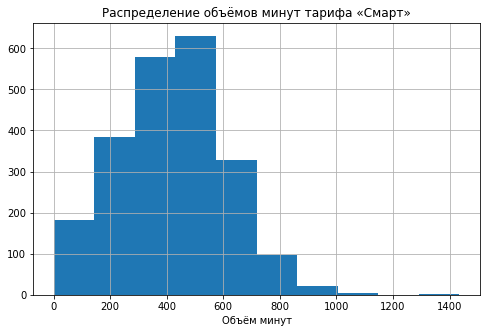

In [76]:
buildHist(smart['call_vol'], 'Объём минут', 'Распределение объёмов минут тарифа «Смарт»')

Распределение нормальное, большинство пользователей тарифа «Смарт» расходуют порядка 500 минут.

Построим гистограмму частот распределения объёмов минут по пользователям тарифного плана «Ультра», исключив из расчёта значение 0 минут, так как в документации указано, что это пропущенные звонки.

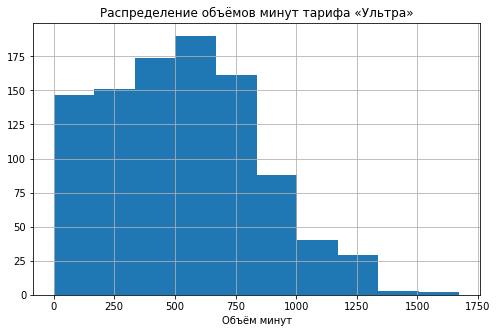

In [77]:
buildHist(ultra['call_vol'], 'Объём минут', 'Распределение объёмов минут тарифа «Ультра»')

Распределение также нормальное, большинство пользователей тарифа «Ультра» расходуют порядка 600 минут.

Сравним распределение метрик двух тарифов.

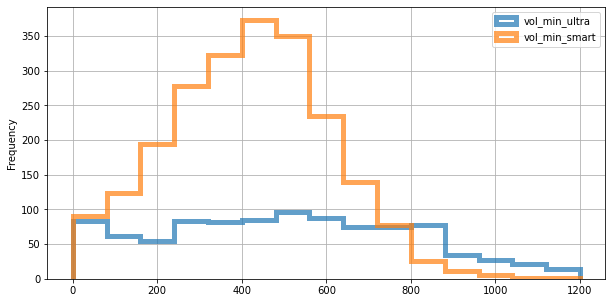

In [78]:
ax = ultra.plot(
    kind='hist',
    y='call_vol',
    histtype='step',
    range=(0, 1200),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_min_ultra',
    figsize=(10,5)
)
smart.plot(
    kind='hist',
    y='call_vol',
    histtype='step',
    range=(0, 1200),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_min_smart',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,5)
);

На данном графике видно, что пользователей тарифа «Смарт» гораздо больше, чем тарифа «Ультра» и распределение объёма минут тарифа «Ультра» имеет более равномерную частоту, то есть количество пользователей, которые расходуют 200, 500 и 800 минут отличается не очень сильно. В то время как на тарифе «Смарт» большинство пользователей расходуют около 500 минут по тарифу.

In [79]:
# среднее значение объёма минут в месяц по тарифам
print('Средний объём минут в месяц на тарифе "Смарт":', smart['call_vol'].mean())
print('Средний объём минут в месяц на тарифе "Ультра":', ultra['call_vol'].mean())

Средний объём минут в месяц на тарифе "Смарт": 417.9349484073576
Средний объём минут в месяц на тарифе "Ультра": 526.6233502538071


**Выводы**

На данном этапе мы проанализировали сколько минут разговора требуется пользователям каждого тарифа в месяц: 419 минут на тарифе «Смарт»  и 525 минут на тарифе «Ультра», стандартное отклонение достаточно большое, что означает широкий разброс значений по данной метрике. Распределение количества минут нормальное, бОльшее количество пользователей тарифа «Смарт» расходуют порядка 400 минут в месяц, тарифа «Ультра» - 500 минут в месяц.

### Анализ количества сообщений пользователей

Построим гистограмму частот распределения объёмов сообщений по пользователям тарифного плана «Смарт».

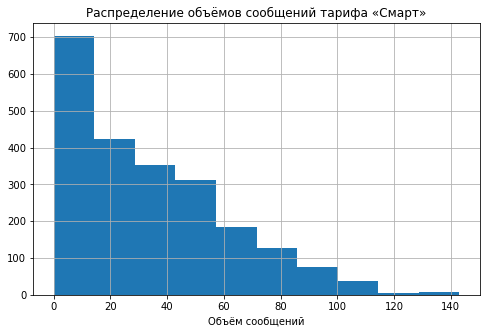

In [80]:
buildHist(smart['mes_count'], 'Объём сообщений', 'Распределение объёмов сообщений тарифа «Смарт»')

Распределение Пуассоновское, большинство пользователей тарифа «Смарт» расходуют порядка 10 сообщений.

Построим гистограмму частот распределения объёмов сообщений по пользователям тарифного плана «Ультра».

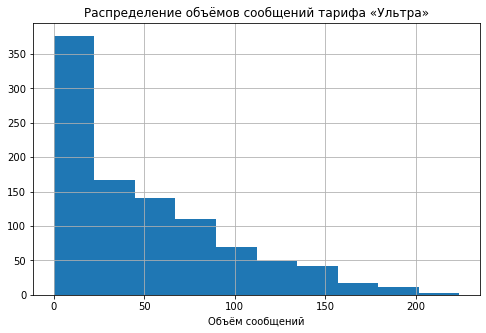

In [81]:
buildHist(ultra['mes_count'], 'Объём сообщений', 'Распределение объёмов сообщений тарифа «Ультра»')

Распределение также Пуассоновское, большинство пользователей тарифа «Ультра» расходуют порядка 20 сообщений.

Сравним распределение метрик двух тарифов.

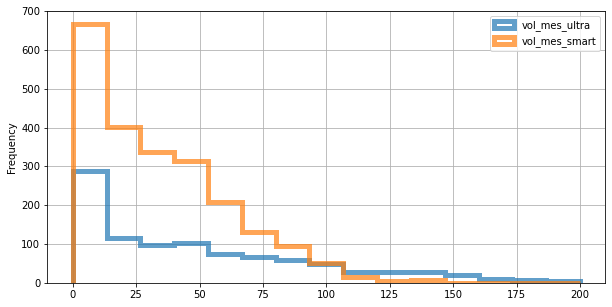

In [82]:
ax = ultra.plot(
    kind='hist',
    y='mes_count',
    histtype='step',
    range=(0, 200),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_mes_ultra',
    figsize=(10,5)
)
smart.plot(
    kind='hist',
    y='mes_count',
    histtype='step',
    range=(0, 200),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_mes_smart',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,5)
);

На данном графике также видно, что пользователей тарифа «Смарт» гораздо больше, чем тарифа «Ультра» и распределение объёма сообщений тарифа «Ультра» имеет более равномерную частоту. В то время как на тарифе «Смарт» большинство пользователей расходуют около 10 сообщений по тарифу.

In [83]:
# среднее значение объёма сообщений в месяц по тарифам
print('Средний объём минут в месяц на тарифе "Смарт":', smart['mes_count'].mean())
print('Средний объём минут в месяц на тарифе "Ультра":', ultra['mes_count'].mean())

Средний объём минут в месяц на тарифе "Смарт": 33.384028712427096
Средний объём минут в месяц на тарифе "Ультра": 49.36345177664975


**Выводы**

На данном этапе мы проанализировали сколько сообщений требуется пользователям каждого тарифа в месяц: 32 шт. на тарифе «Смарт» и 54 шт. на тарифе «Ультра», стандартное отклонение достаточно большое, что означает широкий разброс значений по данной метрике. Распределение количества сообщений Пуассоновское, бОльшее количество пользователей тарифа «Смарт» расходуют порядка 10 сообщений в месяц, тарифа «Ультра» - 20 сообщений в месяц.

### Анализ интернет-трафика пользователей

Построим гистограмму частот распределения объёмов интернет-трафика по пользователям тарифного плана «Смарт».

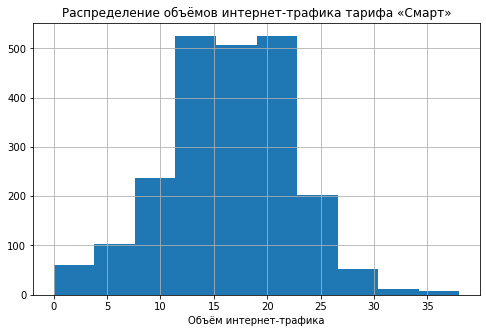

In [84]:
buildHist(smart['gb_used'], 'Объём интернет-трафика', 'Распределение объёмов интернет-трафика тарифа «Смарт»')

Распределение нормальное, большинство пользователей тарифа «Смарт» расходуют порядка 19 гигабайт, при этом заметим, что небольшая часть пользователей вообще не пользуется интернетов на данном тарифе.

Построим гистограмму частот распределения объёмов интернет-трафика по пользователям тарифного плана «Ультра».

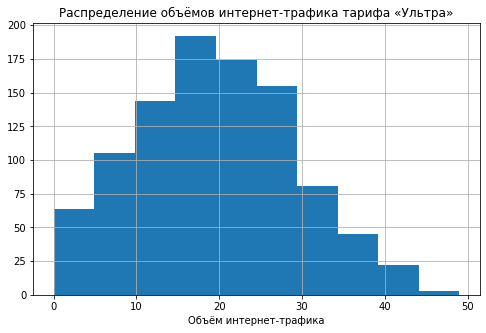

In [85]:
buildHist(ultra['gb_used'], 'Объём интернет-трафика', 'Распределение объёмов интернет-трафика тарифа «Ультра»')

Распределение также нормальное, большинство пользователей тарифа «Ультра» расходуют порядка 18 гигабайт.

Сравним распределение метрик двух тарифов.

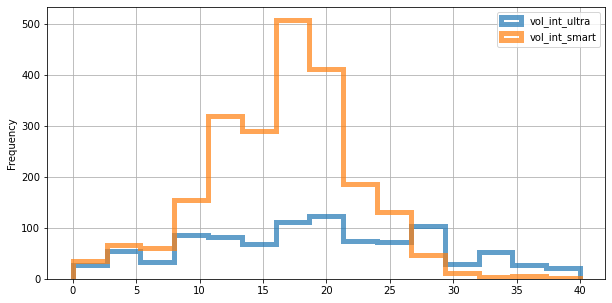

In [86]:
ax = ultra.plot(
    kind='hist',
    y='gb_used',
    histtype='step',
    range=(0, 40),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_int_ultra',
    figsize=(10,5)
)
smart.plot(
    kind='hist',
    y='gb_used',
    histtype='step',
    range=(0, 40),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='vol_int_smart',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,5)
);

На данном графике также видно, что пользователей тарифа «Смарт» гораздо больше, чем тарифа «Ультра» и распределение объёма интернет-трафика тарифа «Ультра» имеет более равномерную частоту с небольшим пиком 18 гигабайт. В то время как на тарифе «Смарт» большинство пользователей расходуют около 19 гигабайт по тарифу.

In [87]:
# среднее значение объёма интернет-трафика в месяц по тарифам
print('Средний объём минут в месяц на тарифе "Смарт":', smart['gb_used'].mean())
print('Средний объём минут в месяц на тарифе "Ультра":', ultra['gb_used'].mean())

Средний объём минут в месяц на тарифе "Смарт": 16.328847016599372
Средний объём минут в месяц на тарифе "Ультра": 19.494416243654822


**Выводы**

На данном этапе мы проанализировали сколько интернет-трафика требуется пользователям каждого тарифа в месяц: 17 гигабайт на тарифе «Смарт» и 20 гигабайт на тарифе «Ультра», стандартное отклонение достаточно большое, что означает широкий разброс значений по данной метрике. Распределение объёма интернет-трафика нормальное, бОльшее количество пользователей тарифа «Смарт» расходуют порядка 19 гигабайт в месяц, тарифа «Ультра» - 18 гигабайт в месяц.

### Анализ выручки пользователей

Построим гистограмму частот распределения размера выручки по пользователям тарифного плана «Смарт».

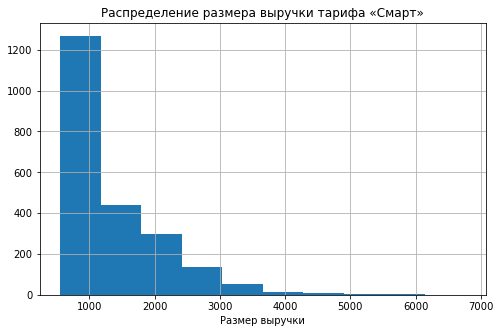

In [88]:
buildHist(smart['revenue'], 'Размер выручки', 'Распределение размера выручки тарифа «Смарт»')

Распределение Пуассоновское, большинство пользователей тарифа «Смарт» расходуют в порядка 700 руб. в месяц.

Построим гистограмму частот распределения размера выручки по пользователям тарифного плана «Ультра».

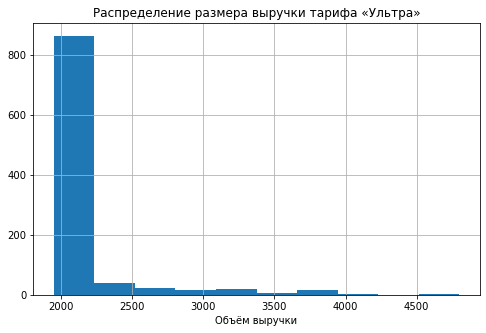

In [89]:
buildHist(ultra['revenue'], 'Объём выручки', 'Распределение размера выручки тарифа «Ультра»')

Распределение также тяготеет к Пуассоновскому, большинство пользователей тарифа «Ультра» расходуют порядка 2000руб. в месяц.

Сравним распределение метрик двух тарифов.

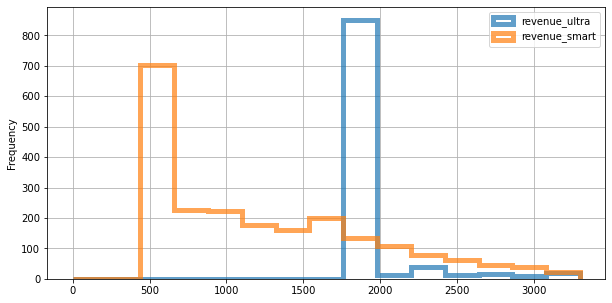

In [90]:
ax = ultra.plot(
    kind='hist',
    y='revenue',
    histtype='step',
    range=(0, 3300),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='revenue_ultra',
    figsize=(10,5)
)
smart.plot(
    kind='hist',
    y='revenue',
    histtype='step',
    range=(0, 3300),
    bins=15,
    linewidth=5,
    alpha=0.7,
    label='revenue_smart',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,5)
);

На данном графике видно, что почти все пользователи тарифа «Ультра» приносят выручку в размере 2000руб. и их количество даже больше, чем количество пользователей тарифа «Смарт» приносящих самую частотную выручку на этом тарифе - 700руб.

In [91]:
# среднее значение выручки в месяц по тарифам
print('Средняя выручка в месяц на тарифе "Смарт":', smart['revenue'].mean())
print('Средняя выручка в месяц на тарифе "Ультра":', ultra['revenue'].mean())

Средняя выручка в месяц на тарифе "Смарт": 1289.9735307312696
Средняя выручка в месяц на тарифе "Ультра": 2070.1522842639592


**Выводы**

На данном этапе мы проанализировали выручку пользователей каждого тарифа в месяц: 1044 руб. на тарифе «Смарт» и 2011 руб. на тарифе «Ультра». Распределение выручки пользователей тяготеет к Пуассоновскому, бОльшее количество пользователей тарифа «Смарт» приносят выручку порядка 700 руб. в месяц, почти все пользователи тарифа «Ультра» - 2000 руб. в месяц.

### Выводы

На данном этапе мы проанализировали сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитали среднее количество и стандартное отклонение, посмотрели минимальные и максимальные значения. Построли гистограммы и описали распределения метрик.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем нулевую и альтернативную гипотезы:
* H0: Cредняя выручка пользователей тарифа «Ультра» равна средней выручке тарифа «Смарт»;
* H1: Cредняя выручка пользователей тарифа «Ультра» не равна средней выручке тарифа «Смарт».

Используем метод scipy.stats.ttest_ind (array1, array2,equal_var), проверим размер выборок пользователей тарифов «Ультра» и «Смарт» и дисперсии выручки на тарифах для того чтобы принять решение о значении параметра equal_var.

In [92]:
print('Размер выборки пользователей тарифов «Ультра»:', len(ultra['user_id']))
print('Размер выборки пользователей тарифов «Смарт»:', len(smart['user_id']))

Размер выборки пользователей тарифов «Ультра»: 985
Размер выборки пользователей тарифов «Смарт»: 2229


In [93]:
# установим ddof=1, так как в нашем датасете только часть пользователей исследуемых тарифных планов
variance_estimate_ultra = np.var(ultra['revenue'], ddof=1)
variance_estimate_smart = np.var(smart['revenue'], ddof=1)
print('Дисперсия выручки тарифа «Ультра»:', variance_estimate_ultra)
print('Дисперсия выручки тарифа «Смарт»:', variance_estimate_smart)

Дисперсия выручки тарифа «Ультра»: 141516.745078617
Дисперсия выручки тарифа «Смарт»: 669785.7080064153


Так как размеры выборок разные и дисперсии не равны, устанавливаем значение параметра equal_var = False.

In [94]:
# проверка гипотезы
# зададим критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу
alpha = .01

results = st.ttest_ind(
    ultra['revenue'], 
    smart['revenue'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Отклоняем нулевую гипотезу в пользу альтернативной = Cредняя выручка пользователей тарифа «Ультра» не равна средней выручке тарифа «Смарт».

Однако, чтобы понять какой из двух тарифных планов («Смарт» или «Ультра») приносит компании «Мегалайн» больше денег не достаточно проверить только равенство или неравенство, необходимос также узнать выручка от какого тарифа больше.

Сформулируем нулевую и альтернативную гипотезы:
* H0: Cредняя выручка тарифа «Смарт» равна 2011 руб. (размер средней выручки тарифа «Ультра»);
* H1: Cредняя выручка тарифа «Смарт» меньше 2011 руб. (размер средней выручки тарифа «Ультра»).

In [95]:
prev_screens_value = 2011

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    smart['revenue'], 
    prev_screens_value)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (smart['revenue'].mean() < prev_screens_value):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.2050177943521484e-280
Отвергаем нулевую гипотезу


Отклоняем нулевую гипотезу в пользу альтернативной = Cредняя выручка тарифа «Смарт» меньше 2011 руб. (размер средней выручки тарифа «Ультра»).

**Выводы**

Гипотеза Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются подтвердилась, при этом средняя выручка тарифного плана «Смарт» меньше, чем средняя выручка тарифного плана «Ультра».

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для того чтобы проверить данную гипотезу сохраним в отдельные переменные данные пользователей из Москвы и из других регионов.

In [96]:
df_final.head()

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
0,1000,-1,Краснодар,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1950.0
1,1000,-1,Краснодар,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1950.0
2,1000,-1,Краснодар,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1950.0
3,1000,-1,Краснодар,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1950.0
4,1000,-1,Краснодар,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1950.0


In [97]:
# данные пользователей из Москвы 
df_msk = df_final.query('city == "Москва"')
df_msk.head()

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
8,1001,-1,Москва,2018-11-01,smart,2018-11-01,59.0,430.0,0.0,18.0,1150.0
9,1001,-1,Москва,2018-11-01,smart,2018-12-01,63.0,414.0,0.0,14.0,550.0
17,1003,-1,Москва,2018-08-17,ultra,2018-08-01,55.0,380.0,37.0,9.0,1950.0
18,1003,-1,Москва,2018-08-17,ultra,2018-09-01,134.0,961.0,91.0,13.0,1950.0
19,1003,-1,Москва,2018-08-17,ultra,2018-10-01,108.0,855.0,83.0,15.0,1950.0


In [98]:
# данные пользователей из других регионов
df_other = df_final.query('city != "Москва"')
df_other.head()

,user_id,churn_date,city,reg_date,tariff,month,call_count,call_vol,mes_count,gb_used,revenue
0,1000,-1,Краснодар,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,3.0,1950.0
1,1000,-1,Краснодар,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,23.0,1950.0
2,1000,-1,Краснодар,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,14.0,1950.0
3,1000,-1,Краснодар,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,14.0,1950.0
4,1000,-1,Краснодар,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,15.0,1950.0


Сформулируем нулевую и альтернативную гипотезы:
* H0: Cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;
* H1: Cредняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

Рассчитаем среднюю выручку пользователей из Москвы и из других регионов.

In [99]:
print('Размер средней выручки пользователей из Москвы:', df_msk['revenue'].mean())
print('Размер средней выручки пользователей из других регионов:', df_other['revenue'].mean())

Размер средней выручки пользователей из Москвы: 1546.7135842880523
Размер средней выручки пользователей из других регионов: 1524.9362274298885


Используем метод scipy.stats.ttest_ind (array1, array2,equal_var), проверим размер выборок пользователей из Москвы и из других регионов и дисперсии выручки по этим группам для того чтобы принять решение о значении параметра equal_var.

In [100]:
print('Размер выборки пользователей из Москвы:', len(df_msk['user_id']))
print('Размер выборки пользователей из других регионов:', len(df_other['user_id']))

Размер выборки пользователей из Москвы: 611
Размер выборки пользователей из других регионов: 2603


In [101]:
# установим ddof=1, так как в нашем датасете только часть пользователей от общей базы
variance_estimate_msk = np.var(df_msk['revenue'], ddof=1)
variance_estimate_other = np.var(df_other['revenue'], ddof=1)
print('Дисперсия выручки пользователей из Москвы:', variance_estimate_msk)
print('Дисперсия выручки пользователей из других регионов:', variance_estimate_other)

Дисперсия выручки пользователей из Москвы: 565636.4670118855
Дисперсия выручки пользователей из других регионов: 654137.6285218045


Так как размеры выборок очень разные и дисперсии не равны, устанавливаем значение параметра equal_var = False.

In [102]:
# проверка гипотезы
# зададим критический уровень статистической значимости, если p-value окажется меньше него - отвегнем гипотезу
alpha = .01

results = st.ttest_ind(
    df_msk['revenue'], 
    df_other['revenue'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


На основании полученных данных не можем отклонить нулевую гипотезу. Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 53%, хотя средняя выручка пользователей из Москвы и других регионов отличается. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между значениями средней выручки пользователей из двух групп.

**Выводы**

Гипотеза Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтвердилась.

### Выводы

Проверка гипотез показала, что гипотеза о средней выручке пользователей тарифов «Ультра» и «Смарт» подтвердилась, а гипотеза о средней выручке пользователей из Москвы и других регионов - нет.

## Общий вывод

Исследование проводилось в 4 этапа:
 1. На этапе Обзор данных мы ознакомились с данными во всех предоставленных таблицах, обнаружили пропуски, некоректные названия столбцов, определили дальнейший план обработки данных и зафиксировали, что предварительно данных для проведения исследования достаточно.
 2. На этапе Предобработка данных мы обработали пропуски, исправили названия столбцов, рассчитали количество израсходованных минут разговора, количество отправленных сообщений, объем израсходованного интернет-трафика по месяцам, а также помесячную выручку с каждого пользователя.
 3. На этапе Исследовательский анализ данных мы проанализировали:
     * сколько в среднем минут разговора требуется пользователям каждого тарифа в месяц и выяснили, что пользователи обоих тарифов не расходуют полностью пакеты минут, но при этом на тарифе «Смарт» пользователи почти полностью выговаривают пакет;
     * сколько в среднем сообщений требуется пользователям каждого тарифа в месяц и выяснили, что пользователи пользователи обоих тарифов в среднем не расходуют полностью пакеты сообщений;
     * сколько в среднем интернет-трафика требуется пользователям каждого тарифа в месяц и выяснили, что пользователи тарифа «Смарт» перерасходуют пакет интернет-трафика, а пользователи тарифа «Ультра» не расходуют полностью пакеты интернета;
     * среднемесячную выручку пользователей и выяснили, что на тарифе «Смарт» это 1044 руб. и на тарифе «Ультра» - 2011 руб. При этом бОльшее количество пользователей тарифа «Смарт» приносят выручку порядка 700 руб. в месяц, почти все пользователи тарифа «Ультра» - 2000 руб. в месяц.
 4. На этапе Проверка гипотез мы выявили, что гипотеза Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются подтвердилась, а ипотеза о том, что средняя выручка пользователей из Москвы и других регионов отличается не подтвердилась.

По результатам исследования можно сделать следующий вывод: тарифный план «Ультра» приносит компании «Мегалайн» больше денег, чем тарифный план «Смарт».

Можно рекомендовать скорректировать рекламный бюджет компании «Мегалайн» в пользу продвижения тарифного плана «Ультра».